In [23]:
# !pip install sortedcollections graphviz
 
import graphviz
import numpy as np
import pandas as pd
from collections import OrderedDict
from sortedcollections import OrderedSet

In [24]:
# u = 'w'
# V = OrderedSet(sorted('wxyz'))
# edges = {
#     ('w', 'x'): 1,
#     ('w', 'y'): 2,
#     ('x', 'z'): 2,
#     ('y', 'z'): 1,
# }

# u = "a"
# V = OrderedSet(sorted("abcde"))
# edges = {
#     ("a", "b"): 2,
#     ("a", "c"): 1,
#     ("b", "e"): 1,
#     ("b", "d"): 4,
#     ("d", "c"): 8,
#     ("c", "e"): 6,
#     ("d", "e"): 1,
# }

# u = "u"
# V = OrderedSet(sorted("uvwxyz"))
# edges = {
#     ("u", "w"): 7,
#     ("u", "v"): 3,
#     ("u", "x"): 7,
#     ("v", "x"): 3,
#     ("v", "w"): 7,
#     ("x", "w"): 1,
#     ("x", "y"): 7,
#     ("w", "z"): 7,
#     ("w", "y"): 6,
#     ("y", "z"): 3,
# }

u = 'u'
V = OrderedSet(sorted('uvwxyz'))
edges = {
    ('u', 'w'): 3,
    ('u', 'v'): 7,
    ('u', 'x'): 5,
    ('v', 'w'): 3,
    ('w', 'x'): 4,
    ('w', 'y'): 8,
    ('x', 'y'): 7,
    ('v', 'y'): 4,
    ('x', 'z'): 9,
    ('y', 'z'): 2,
}

In [25]:
# # ab2,ac1,be1,bd4,dc8,ce6,de1
# # ab3,bc1,cd2,de3,ef4,fg5,ge2,dk1,kl7,lb8,lm9,ma0

# x = input()

# u = x[0]
# V = OrderedSet(sorted(filter(lambda c: c.isalpha(), x)))
# edges = {tuple(e): int(w) for *e, w in x.split(",")}

# print(u)
# print(V)
# print(edges)

In [26]:
class BiDict(OrderedDict):
    """https://stackoverflow.com/questions/1456373/two-way-reverse-map"""

    def __setitem__(self, key: tuple, value):
        if key in self:
            del self[key]

        OrderedDict.__setitem__(self, key, value)
        OrderedDict.__setitem__(self, key[::-1], value)

    def __delitem__(self, key):
        OrderedDict.__delitem__(self, key)
        OrderedDict.__delitem__(self, key[::-1])

In [27]:
class Node:
    def __init__(self, value, dist=0, prev=None):
        self.value = value
        self.dist = dist
        self.prev = prev  # predecessor node along shortest path from source to self

    def __repr__(self):
        return self.value

    def __str__(self):
        return f"{self.dist},{self.prev!r}" if self.dist != np.inf else str(np.inf)

    def __getitem__(self, q):
        """Returns the dist from p to q if neighbors; otherwise, infinity"""
        return lookup[self][q]

    @property
    def neighbors(self):
        return OrderedSet(filter(lambda u: (self.value, u.value) in E, G))

In [28]:
def check(path, cycle=True, connected=True):
    """Check if a graph is acyclic and/or connected.

    While performing a depth-first search on the graph, a cycle
    is found if any neighbors have already been explored. As such
    the algorithm will not maintain a list of visited nodes. The
    graph is unconnected if not all nodes have been explored.
    """
    G = {n: set(v for u, v in path if u == n) for n in V}
    
    stack, visited = list(u), set()
    while stack:
        visited.add(n := stack.pop())
        stack.extend(G[n] if cycle else G[n] - visited - set(stack))
        # NOTE: if cycle, we don't check the stack as those nodes
        # pertaining to a cycle will eventually become visited
        if any(u in visited for u in stack):
            raise AssertionError("cycle found")
    if connected and V != visited:
        raise AssertionError(f"nodes {V - visited} were not connected")

In [29]:
E = BiDict(**edges)
check(E, cycle=False)

In [30]:
path = set()
init = Node(value=u)

graph = OrderedSet(
    map(lambda v: Node(value=v, dist=E.get((u, v), np.inf), prev=init), V - {u})
)
visited = OrderedSet({init})

G = visited | graph
lookup = OrderedDict(
    {u: OrderedDict({v: E.get((u.value, v.value), np.inf) for v in G - {u}}) for u in G}
)

In [31]:
headers = [(f"D({v!r}),p({v!r})", [str(v)]) for v in graph]
table = OrderedDict([("N'", [u]), *headers])

In [32]:
for _ in range(1, len(V)):
    p = min(graph - visited, key=lambda u: u.dist)

    visited.add(p)
    path.add((p.prev.value, p.value))

    table["N'"].append("".join(map(repr, visited)))
    print(f"===NODE {p!r}===")

    for q in p.neighbors - visited:
        print(
            f"D({q!r}) = min(D({q!r}), D({p!r}) + C({p!r}, {q!r})) =",
            f"min({q.dist}, {p.dist} + {p[q]}) =",
            f"min({q.dist}, {p.dist + p[q]}) =",
            min(q.dist, p.dist + p[q]),
        )

        # NOTE: if the algorithm finds another path from p to q with the same dist/cost,
        # it will change paths/routes (aka, change parents)
        if p.dist + p[q] <= q.dist:
            q.dist = p.dist + p[q]
            q.prev = p

        table[f"D({q!r}),p({q!r})"].append(str(q))

    for q in graph - p.neighbors - visited:  # unreachable and unvisited nodes from p
        table[f"D({q!r}),p({q!r})"].append(str(q))

===NODE w===
D(v) = min(D(v), D(w) + C(w, v)) = min(7, 3 + 3) = min(7, 6) = 6
D(x) = min(D(x), D(w) + C(w, x)) = min(5, 3 + 4) = min(5, 7) = 5
D(y) = min(D(y), D(w) + C(w, y)) = min(inf, 3 + 8) = min(inf, 11) = 11
===NODE x===
D(y) = min(D(y), D(x) + C(x, y)) = min(11, 5 + 7) = min(11, 12) = 11
D(z) = min(D(z), D(x) + C(x, z)) = min(inf, 5 + 9) = min(inf, 14) = 14
===NODE v===
D(y) = min(D(y), D(v) + C(v, y)) = min(11, 6 + 4) = min(11, 10) = 10
===NODE y===
D(z) = min(D(z), D(y) + C(y, z)) = min(14, 10 + 2) = min(14, 12) = 12
===NODE z===


In [33]:
for i, j in enumerate(sorted(table.values(), key=len, reverse=True)):
    j.extend(["---"] * i)

In [34]:
check(path)

In [35]:
print(pd.DataFrame(table).to_markdown(tablefmt="rounded_grid"))

╭────┬────────┬─────────────┬─────────────┬─────────────┬─────────────┬─────────────╮
│    │ N'     │ D(v),p(v)   │ D(w),p(w)   │ D(x),p(x)   │ D(y),p(y)   │ D(z),p(z)   │
├────┼────────┼─────────────┼─────────────┼─────────────┼─────────────┼─────────────┤
│  0 │ u      │ 7,u         │ 3,u         │ 5,u         │ inf         │ inf         │
├────┼────────┼─────────────┼─────────────┼─────────────┼─────────────┼─────────────┤
│  1 │ uw     │ 6,w         │ ---         │ 5,u         │ 11,w        │ inf         │
├────┼────────┼─────────────┼─────────────┼─────────────┼─────────────┼─────────────┤
│  2 │ uwx    │ 6,w         │ ---         │ ---         │ 11,w        │ 14,x        │
├────┼────────┼─────────────┼─────────────┼─────────────┼─────────────┼─────────────┤
│  3 │ uwxv   │ ---         │ ---         │ ---         │ 10,v        │ 14,x        │
├────┼────────┼─────────────┼─────────────┼─────────────┼─────────────┼─────────────┤
│  4 │ uwxvy  │ ---         │ ---         │ ---       

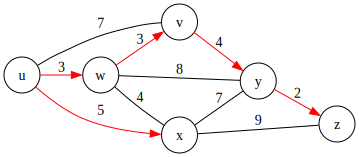

In [36]:
sptree = graphviz.Graph(
    "Dijkstra's Link State Algorithm",
    filename="spanning_tree",
    graph_attr={"rankdir": "LR"},
    node_attr={"shape": "circle"},
)

[sptree.node(v) for v in V]
[sptree.edge(u, v, dir="forward", label=str(E[(u, v)]), color="Red") for u, v in path]
[
    sptree.edge(u, v, label=str(E[(u, v)]))
    for (u, v) in edges
    if {u, v} not in map(set, path)
]

sptree